#### Exercise 1 - Kaggle Small Dataset - Congressional Voting

This dataset contains information on different congress members. The goal here is to analyze the data and predict the part of the congress member. 

##### Important Libraries

In [7]:
import pandas as pd
import numpy as np
from scipy.io import arff
import seaborn as sns
import matplotlib.pyplot as plt
import openml


#sklearn
from sklearn.model_selection import train_test_split 
from sklearn import tree
from sklearn.metrics import recall_score,accuracy_score,confusion_matrix, ConfusionMatrixDisplay, precision_score, make_scorer


from sklearn.model_selection import GridSearchCV


#### Loading the data

In [9]:
df_congress = pd.read_csv('data/CongressionalVotingID.shuf.lrn.csv')

In [12]:
df_congress.head(5)

,ID,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,249,republican,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
1,140,democrat,y,n,y,n,n,y,y,y,y,n,n,n,n,n,y,y
2,383,democrat,y,y,n,y,y,y,n,n,n,n,y,n,y,y,n,unknown
3,201,democrat,n,n,y,n,n,n,y,y,y,n,n,n,n,y,y,y
4,297,republican,n,n,y,y,y,y,n,n,n,y,n,y,y,y,y,y


#### Data exploration and preprocessing

In [14]:
# Number of samples and number of attributes
num_samples = df_congress.shape[0]
num_attributes = df_congress.shape[1] - 1 # last one is the class annotation
print("The number of samples is: ", str(num_samples))
print("The number of attributes is: ", str(num_attributes))

The number of samples is:  218
The number of attributes is:  17


In [15]:
# print number of unknown values:
num_unknown = 0
for n in df_congress.columns:
  num_unknown_per_feature = df_congress.loc[:,n].isin(['unknown']).sum(axis=0)
  num_unknown += num_unknown_per_feature
  print(n, ':', num_unknown_per_feature)
print('total unknown:', num_unknown)

#for the moment, I decided to keep these missing values as they are

ID : 0
class : 0
handicapped-infants : 7
water-project-cost-sharing : 21
adoption-of-the-budget-resolution : 4
physician-fee-freeze : 6
el-salvador-aid : 9
religious-groups-in-schools : 5
anti-satellite-test-ban : 6
aid-to-nicaraguan-contras : 10
mx-missile : 12
immigration : 4
synfuels-crporation-cutback : 13
education-spending : 16
superfund-right-to-sue : 14
crime : 7
duty-free-exports : 14
export-administration-act-south-africa : 58
total unknown: 206


In [18]:
#missing values
df_congress.isna().sum()

ID                                        0
class                                     0
handicapped-infants                       0
water-project-cost-sharing                0
adoption-of-the-budget-resolution         0
physician-fee-freeze                      0
el-salvador-aid                           0
religious-groups-in-schools               0
anti-satellite-test-ban                   0
aid-to-nicaraguan-contras                 0
mx-missile                                0
immigration                               0
synfuels-crporation-cutback               0
education-spending                        0
superfund-right-to-sue                    0
crime                                     0
duty-free-exports                         0
export-administration-act-south-africa    0
dtype: int64

In [43]:
#types of features
df_congress.dtypes

ID                                         int64
class                                     object
handicapped-infants                       object
water-project-cost-sharing                object
adoption-of-the-budget-resolution         object
physician-fee-freeze                      object
el-salvador-aid                           object
religious-groups-in-schools               object
anti-satellite-test-ban                   object
aid-to-nicaraguan-contras                 object
mx-missile                                object
immigration                               object
synfuels-crporation-cutback               object
education-spending                        object
superfund-right-to-sue                    object
crime                                     object
duty-free-exports                         object
export-administration-act-south-africa    object
dtype: object

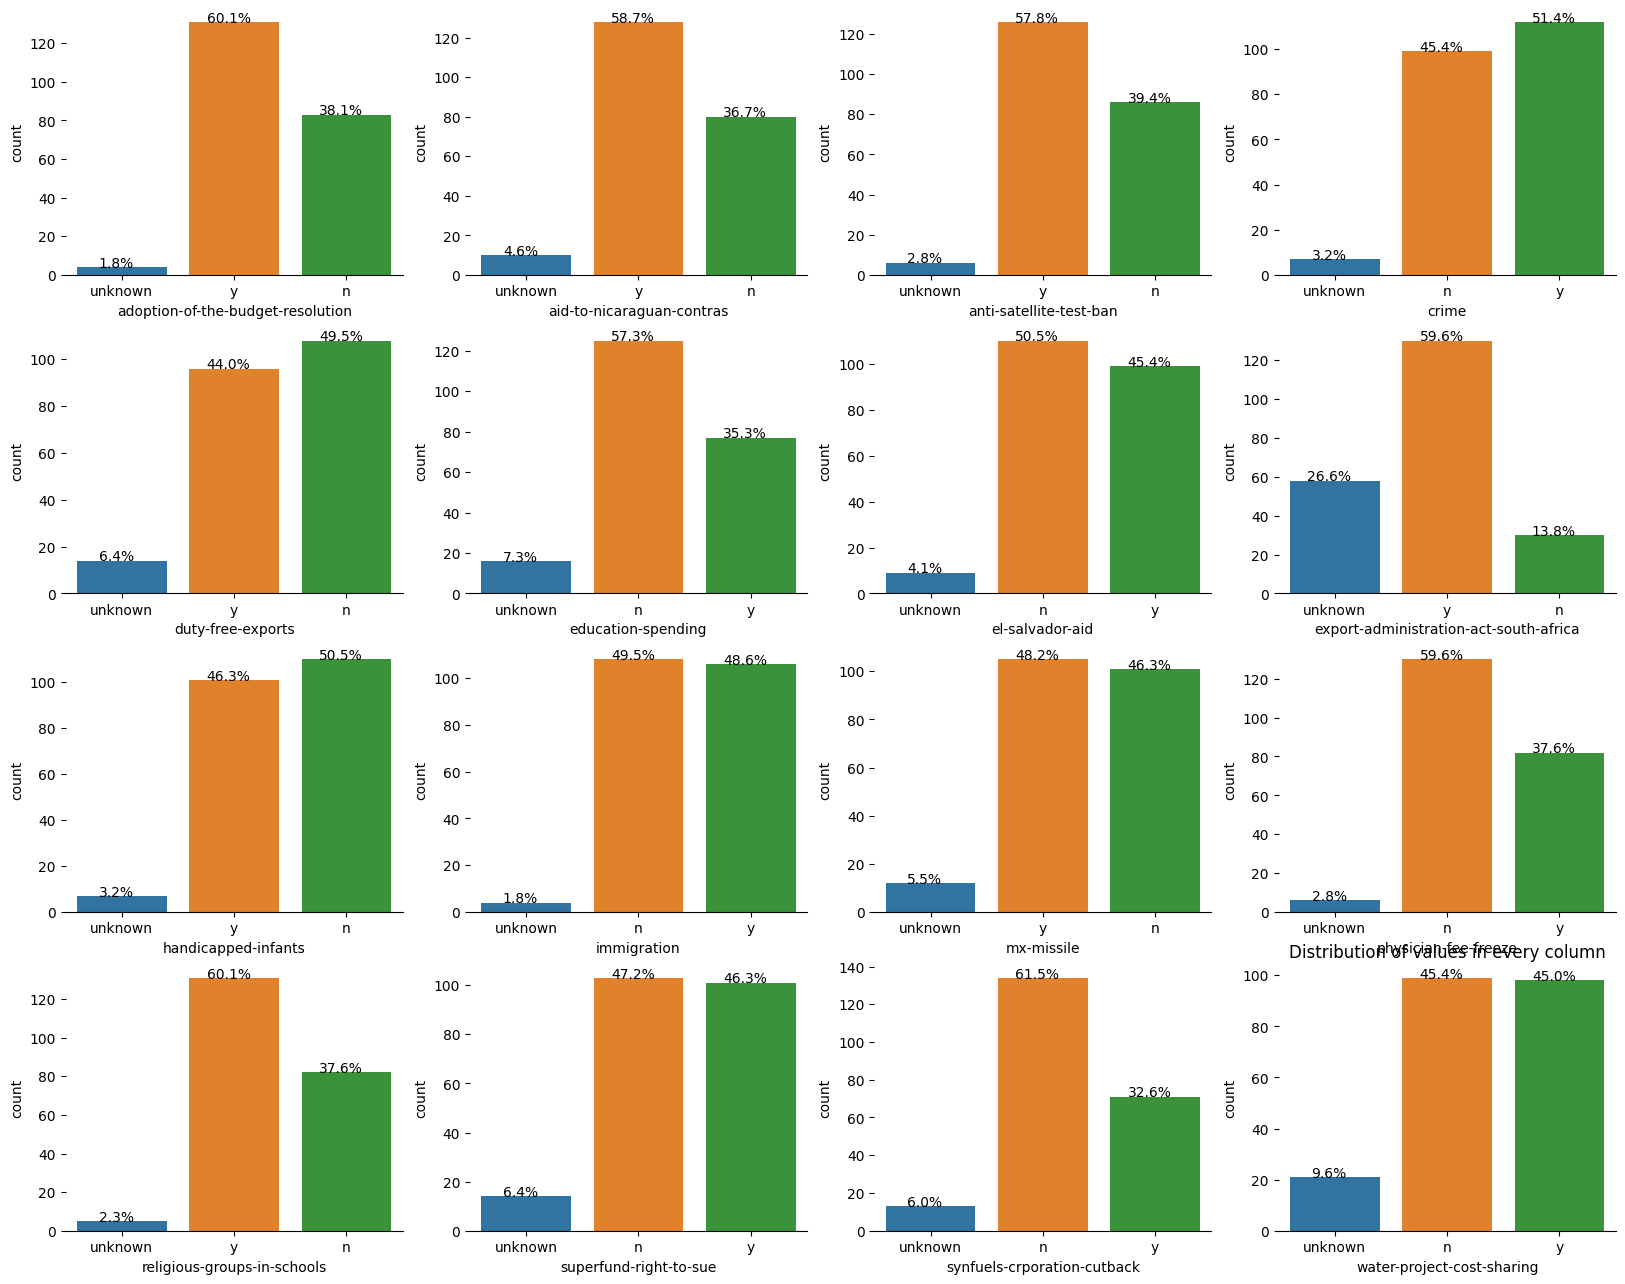

In [48]:
# Plotting the categorical variables
categorical_columns = df_congress.columns.difference(['ID','class'])
plt.figure(figsize=(20,20))
for i, variable in enumerate(categorical_columns):
                     plt.subplot(5,4,i+1)
                     order = df_congress[variable].value_counts(ascending=False).index 
                     ax=sns.countplot(x=df_congress[variable], data=df_congress )
                     sns.despine(top=True,right=True,left=True)
                     for p in ax.patches:
                           percentage = '{:.1f}%'.format(100 * p.get_height()/len(df_congress[variable]))
                           x = p.get_x() + p.get_width() / 2 - 0.05
                           y = p.get_y() + p.get_height()
                           plt.annotate(percentage, (x, y),ha='center')

plt.title('Distribution of values in every column')
plt.show()


Observations:
- `60.1%` of the congressmen voted  for `adoption-of-the-budget-resolution`.
- `58.7%`of the congressmen voted  with `aid-to-nicaraguan-contras`.
- `57.8%`of the congressmen agree with `anti-satellite-test-ban`.
- In the `crime` column `45.4%` have voted against and `51.4%` have voted for. 
- `education-spending` divides the congressmen into `57.3%` no and `35.3%` yes.
- In `duty-free-exports` and `handicapped-infants` the difference between category yes and no is almost 5 in favor of no.
- In `immigration, mix-missile, superfun-right-to-sue and water-project-cost-sharing` the majority have voted against.
- In `superfund-right-to-sue` and `physician-fee-freeze` the majority of votes falls into no category.
- `60.1%` of congressmen voted for `religious-groups-schools`.

ConversionError: Failed to convert value(s) to axis units: array(['republican', 'republican', 'republican', 'republican',
       'republican', 'republican', 'republican', 'republican',
       'republican', 'republican', 'republican', 'republican',
       'republican', 'republican', 'republican', 'republican',
       'republican', 'republican', 'republican', 'republican',
       'republican', 'republican', 'republican', 'republican',
       'republican', 'republican', 'republican', 'republican',
       'republican', 'republican', 'republican', 'republican',
       'republican', 'republican', 'republican', 'republican',
       'republican', 'republican', 'republican', 'republican',
       'republican', 'republican', 'republican', 'republican',
       'republican', 'republican', 'republican', 'republican',
       'republican', 'republican', 'republican', 'republican',
       'republican', 'republican', 'republican', 'republican',
       'republican', 'republican', 'republican', 'republican',
       'republican', 'republican', 'republican', 'republican',
       'republican', 'republican', 'republican', 'republican',
       'republican', 'republican', 'republican', 'republican',
       'republican', 'republican', 'republican', 'republican',
       'republican', 'republican', 'republican', 'republican',
       'republican'], dtype=object)

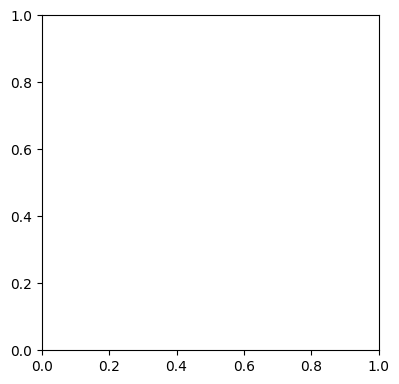

In [69]:
# Histograms for each class
plt.figure(figsize=(20,20))
for i in range(0, 15):
    plt.subplot(4, 4, i+1)
    plt.hist(df_congress[df_congress['class']=='republican'], bins=10, label="republican",color = 'navy')
    plt.hist(df_congress[df_congress['class']=='democrat'], bins=10, label="democrat",color = 'lightcoral')
    plt.xlabel("attribute " + str(i+1) + ": " + str(categorical_columns[i]))
    plt.xticks(rotation=90)
    plt.legend()
plt.suptitle("Overlapping histograms of the attributes' values for 2 classes", fontsize=20)
plt.show()

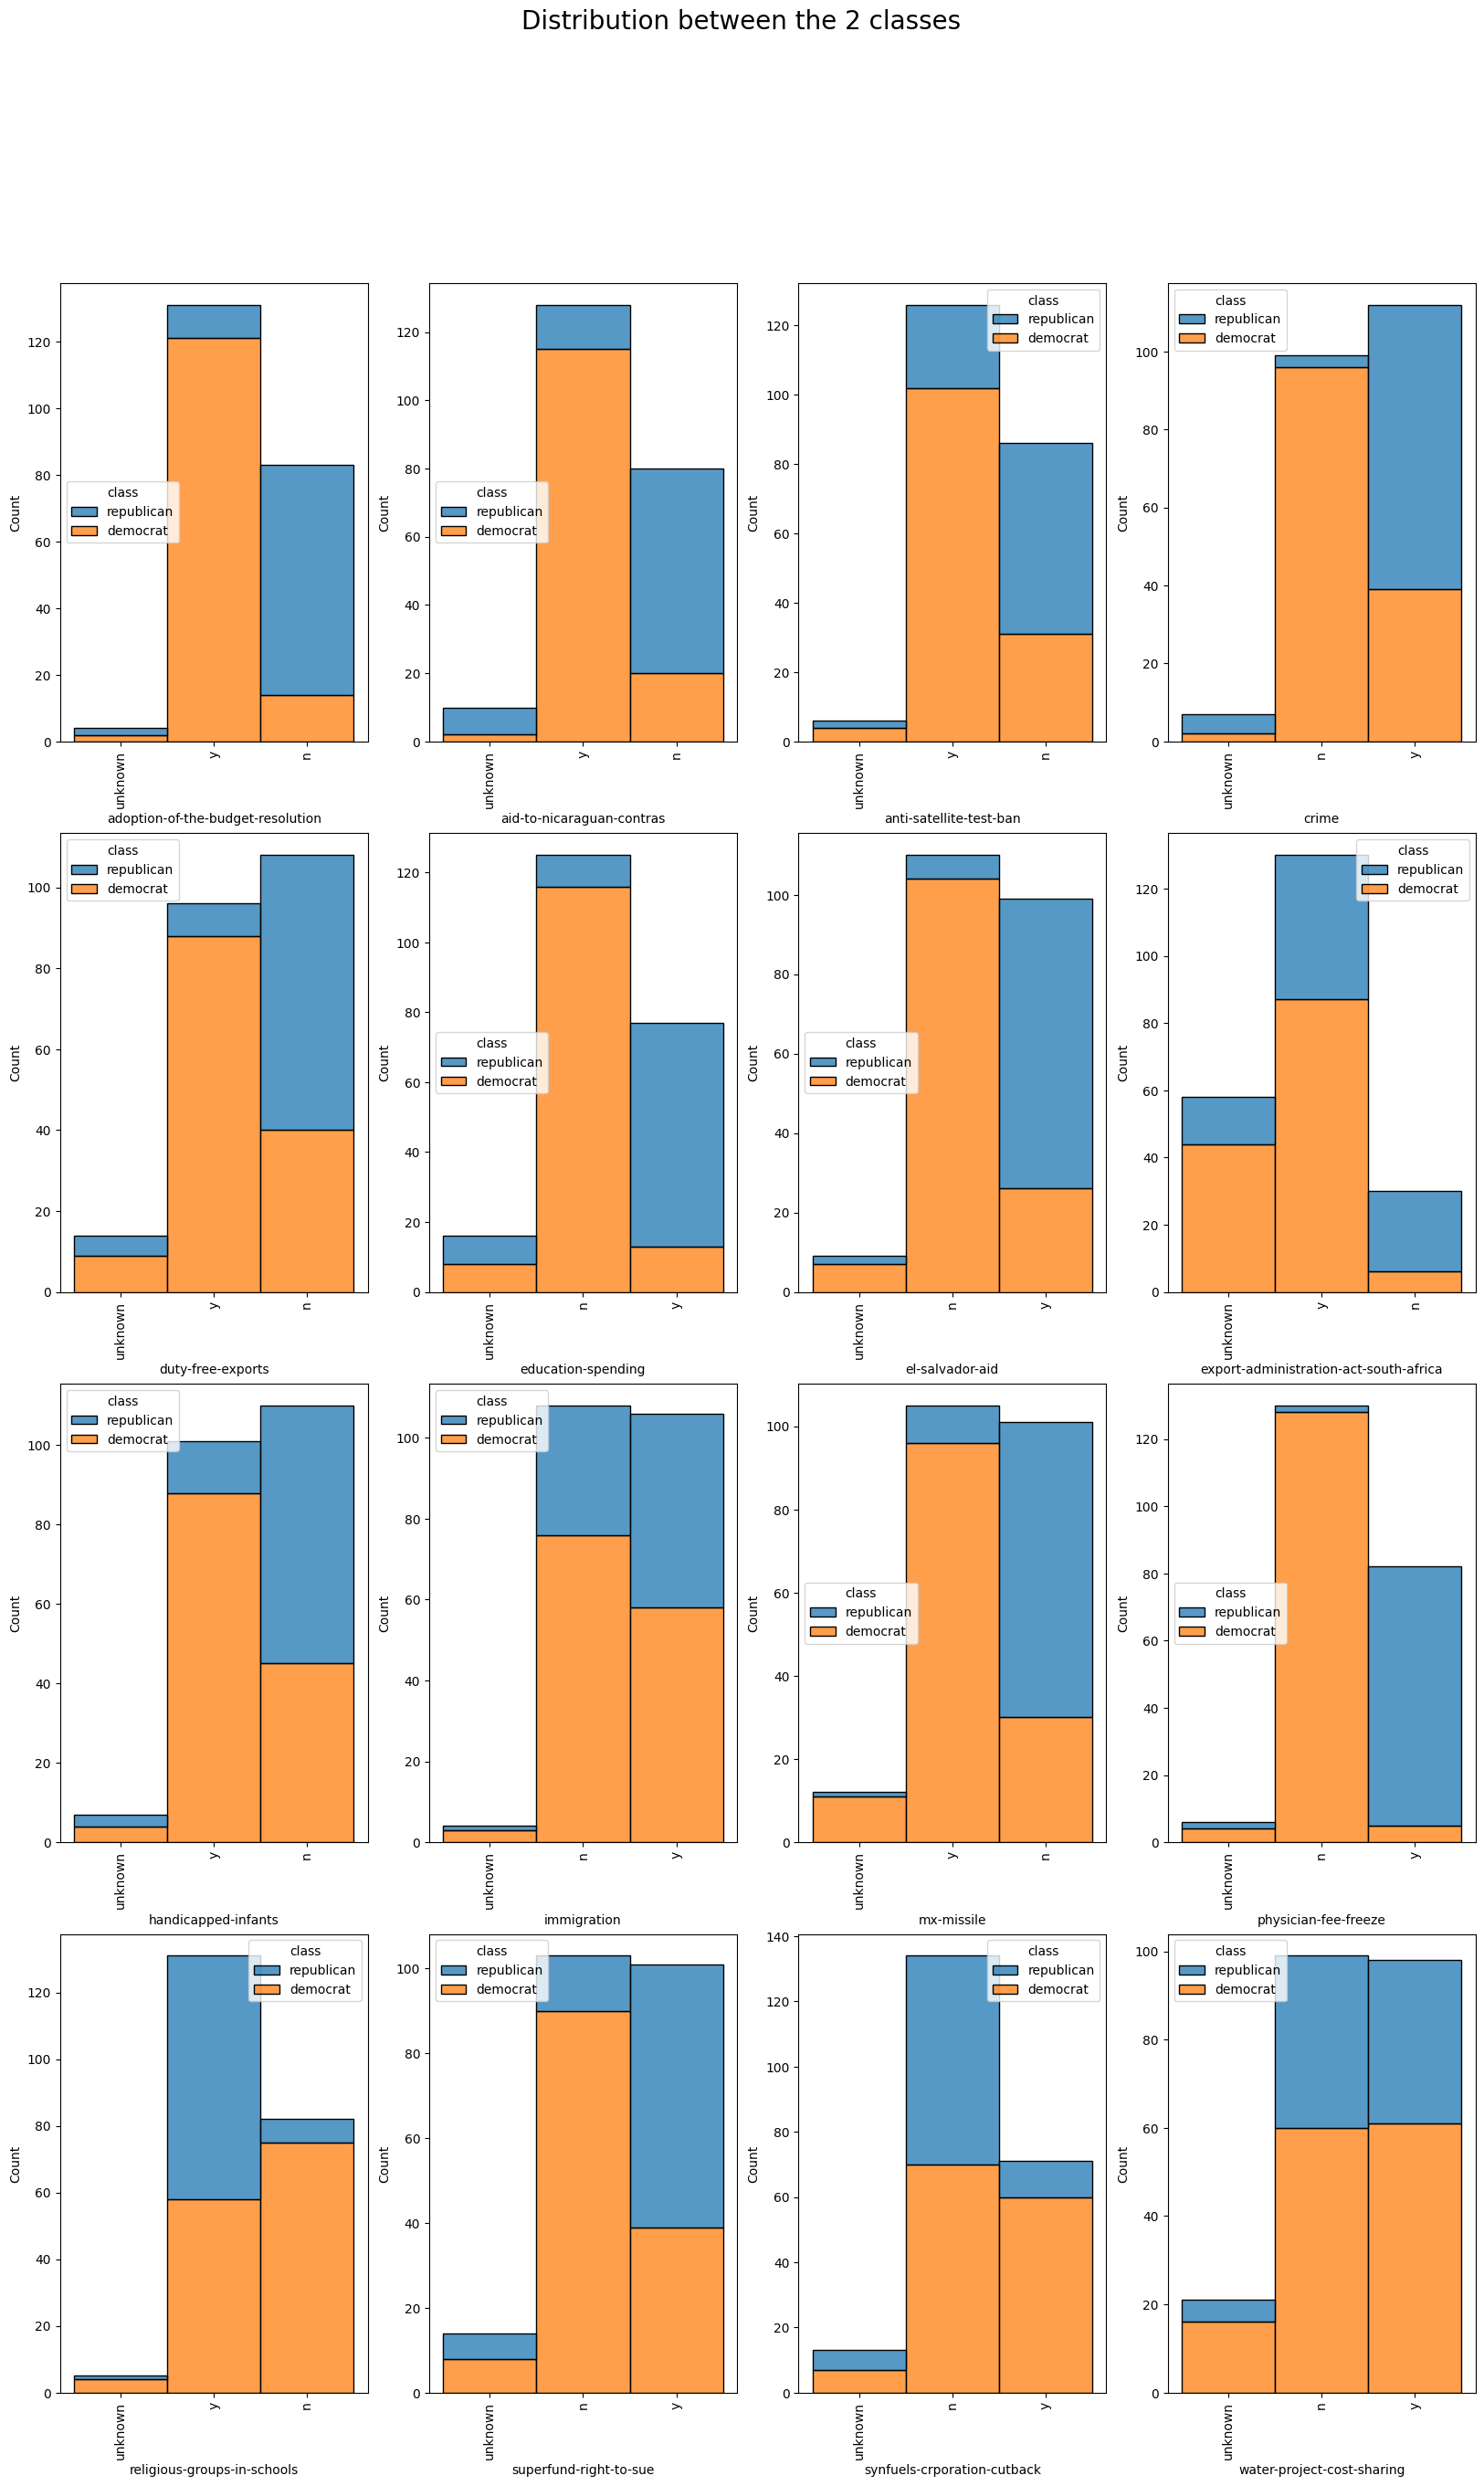

In [70]:

plt.figure(figsize=(20,30))
for i,column in enumerate(categorical_columns):
    plt.subplot(4, 4, i+1)
    sns.histplot(x=df_congress[column],hue =df_congress['class'],multiple = 'stack')
    plt.xlabel(column)
    plt.xticks(rotation=90)
plt.suptitle("Distribution between the 2 classes ", fontsize=20)
plt.show()

Observations:

- The majority of congressmen that have voted for `adoption-of-the-budget-resolution` are democrat
- The majority of congressmen that have voted for `aid-to-nicaragua-contras` are democrat
- The majority of congressmen that have voted for `anti-satellite-test-ban` are democrat
- The majority of congressmen that have voted for `crime` bill are republican
- The majority of congressmen that have voted for `duty-free-exports`are democrat
- The majority of congressmen that have voted for `education-spending` are republican
- The majority of congressmen that have voted for `el-salvador-aid` aew republican
- etc..







##### Converting the categorical columns into dummy variables

In [80]:
df_congress_dummies = pd.get_dummies(df_congress, columns= categorical_columns)

`ID column`

In [81]:
# dropping this column since it does not bring any value
df_congress_dummies.drop('ID', axis=1, inplace=True)

`Class column`

In [83]:
df_congress_dummies['class'] = df_congress_dummies['class'].map({'democrat': 1, 'republican': 0})
df_congress_dummies['class'] = df_congress_dummies['class'].astype('int64')

In [85]:
df_congress_dummies.dtypes

class                                             int64
adoption-of-the-budget-resolution_n               uint8
adoption-of-the-budget-resolution_unknown         uint8
adoption-of-the-budget-resolution_y               uint8
aid-to-nicaraguan-contras_n                       uint8
aid-to-nicaraguan-contras_unknown                 uint8
aid-to-nicaraguan-contras_y                       uint8
anti-satellite-test-ban_n                         uint8
anti-satellite-test-ban_unknown                   uint8
anti-satellite-test-ban_y                         uint8
crime_n                                           uint8
crime_unknown                                     uint8
crime_y                                           uint8
duty-free-exports_n                               uint8
duty-free-exports_unknown                         uint8
duty-free-exports_y                               uint8
education-spending_n                              uint8
education-spending_unknown                      

#### Train and test split

In [87]:
X = df_congress_dummies.drop(['class'], axis=1)
Y = df_congress_dummies['class']

#Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.20, random_state = 1234,stratify=Y)

#### Decision Tree

In [86]:
#Counting the number of samples for each class
print("Number of samples that belong to republican: ", str(len(df_congress[df_congress['class']=='republican'])),len(df_congress[df_congress['class']=='republican'])/len(df_congress), '%')
print("Number of samples that belong to democrat: ", str(len(df_congress[df_congress['class']=='democrat'])),len(df_congress[df_congress['class']=='democrat'])/len(df_congress), '%')

Number of samples that belong to republican:  81 0.37155963302752293 %
Number of samples that belong to democrat:  137 0.6284403669724771 %


- Our dataset is  imbalanced. 63% of the data is represented by democrat congressmen and 37% by repunlican democrats. Since this may have a massive effect on our prediction and the decision trees will surely be biased toward the dominant class, we can make use of the `class_weight` parameter of the model. By passing such a dictionary value {1:0.35, 0:65} to the model parameter, the decision tree will surely give more weightage to class 0.


In [88]:
tree_model_random = tree.DecisionTreeClassifier(class_weight={1:0.35,0:0.65}, random_state=1)
tree_model_random.fit(X_train,y_train)

DecisionTreeClassifier(class_weight={0: 0.65, 1: 0.35}, random_state=1)

In [107]:
def evaluate(model):
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)

    # accuracy
    print("#"*20)
    print("Accuracy on train: ", accuracy_score(y_train, y_train_predict))
    print("Accuracy on test: ", accuracy_score(y_test, y_test_predict))

    print("#"*20)
    print("Confusion Matrix on train:")
    c1 = confusion_matrix(y_train, y_train_predict)
    cmd = ConfusionMatrixDisplay(c1, display_labels=['republican','democrat'])
    cmd.plot(cmap=plt.cm.Blues)
    print("Confusion Matrix on test:")
    c2 = confusion_matrix(y_test, y_test_predict)
    cmd = ConfusionMatrixDisplay(c2, display_labels=['republican','democrat'])
    cmd.plot(cmap=plt.cm.Blues)
    plt.show()
 

####################
Accuracy on train:  1.0
Accuracy on test:  0.9090909090909091
####################
Confusion Matrix on train:
Confusion Matrix on test:


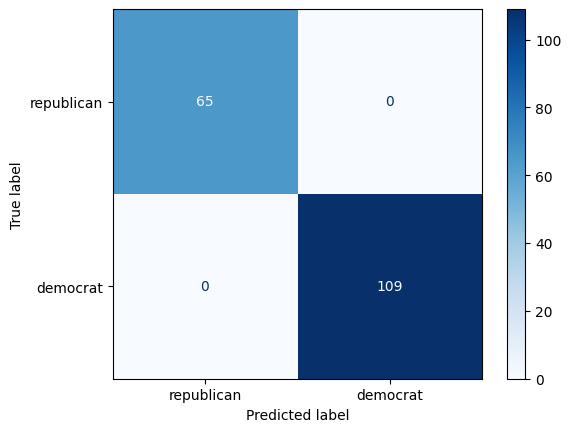

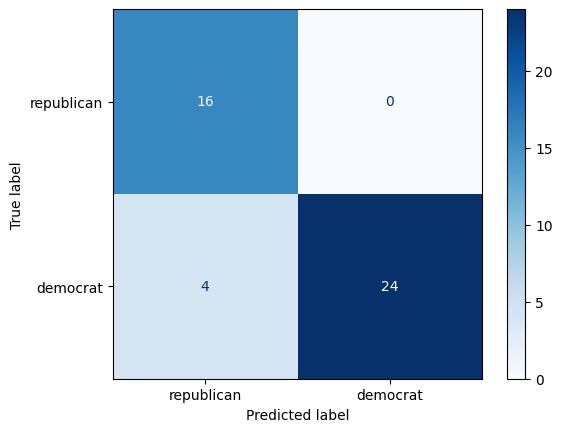

In [108]:
evaluate(tree_model_random)

Observations:
- As seen above, the accuracy score on the train set is perfect which suggests that our model is highly overfitted

In [109]:
#features of the model
features = list(X_train)

In [110]:
def plottree(model):
    plt.figure(figsize=(20,30))
    plot = tree.plot_tree(model,feature_names=features,filled=True,fontsize=9,node_ids=True,class_names=True)
    for o in plot:
        arrow = o.arrow_patch
        if arrow is not None:
            arrow.set_edgecolor('black')
            arrow.set_linewidth(1)
    plt.show()

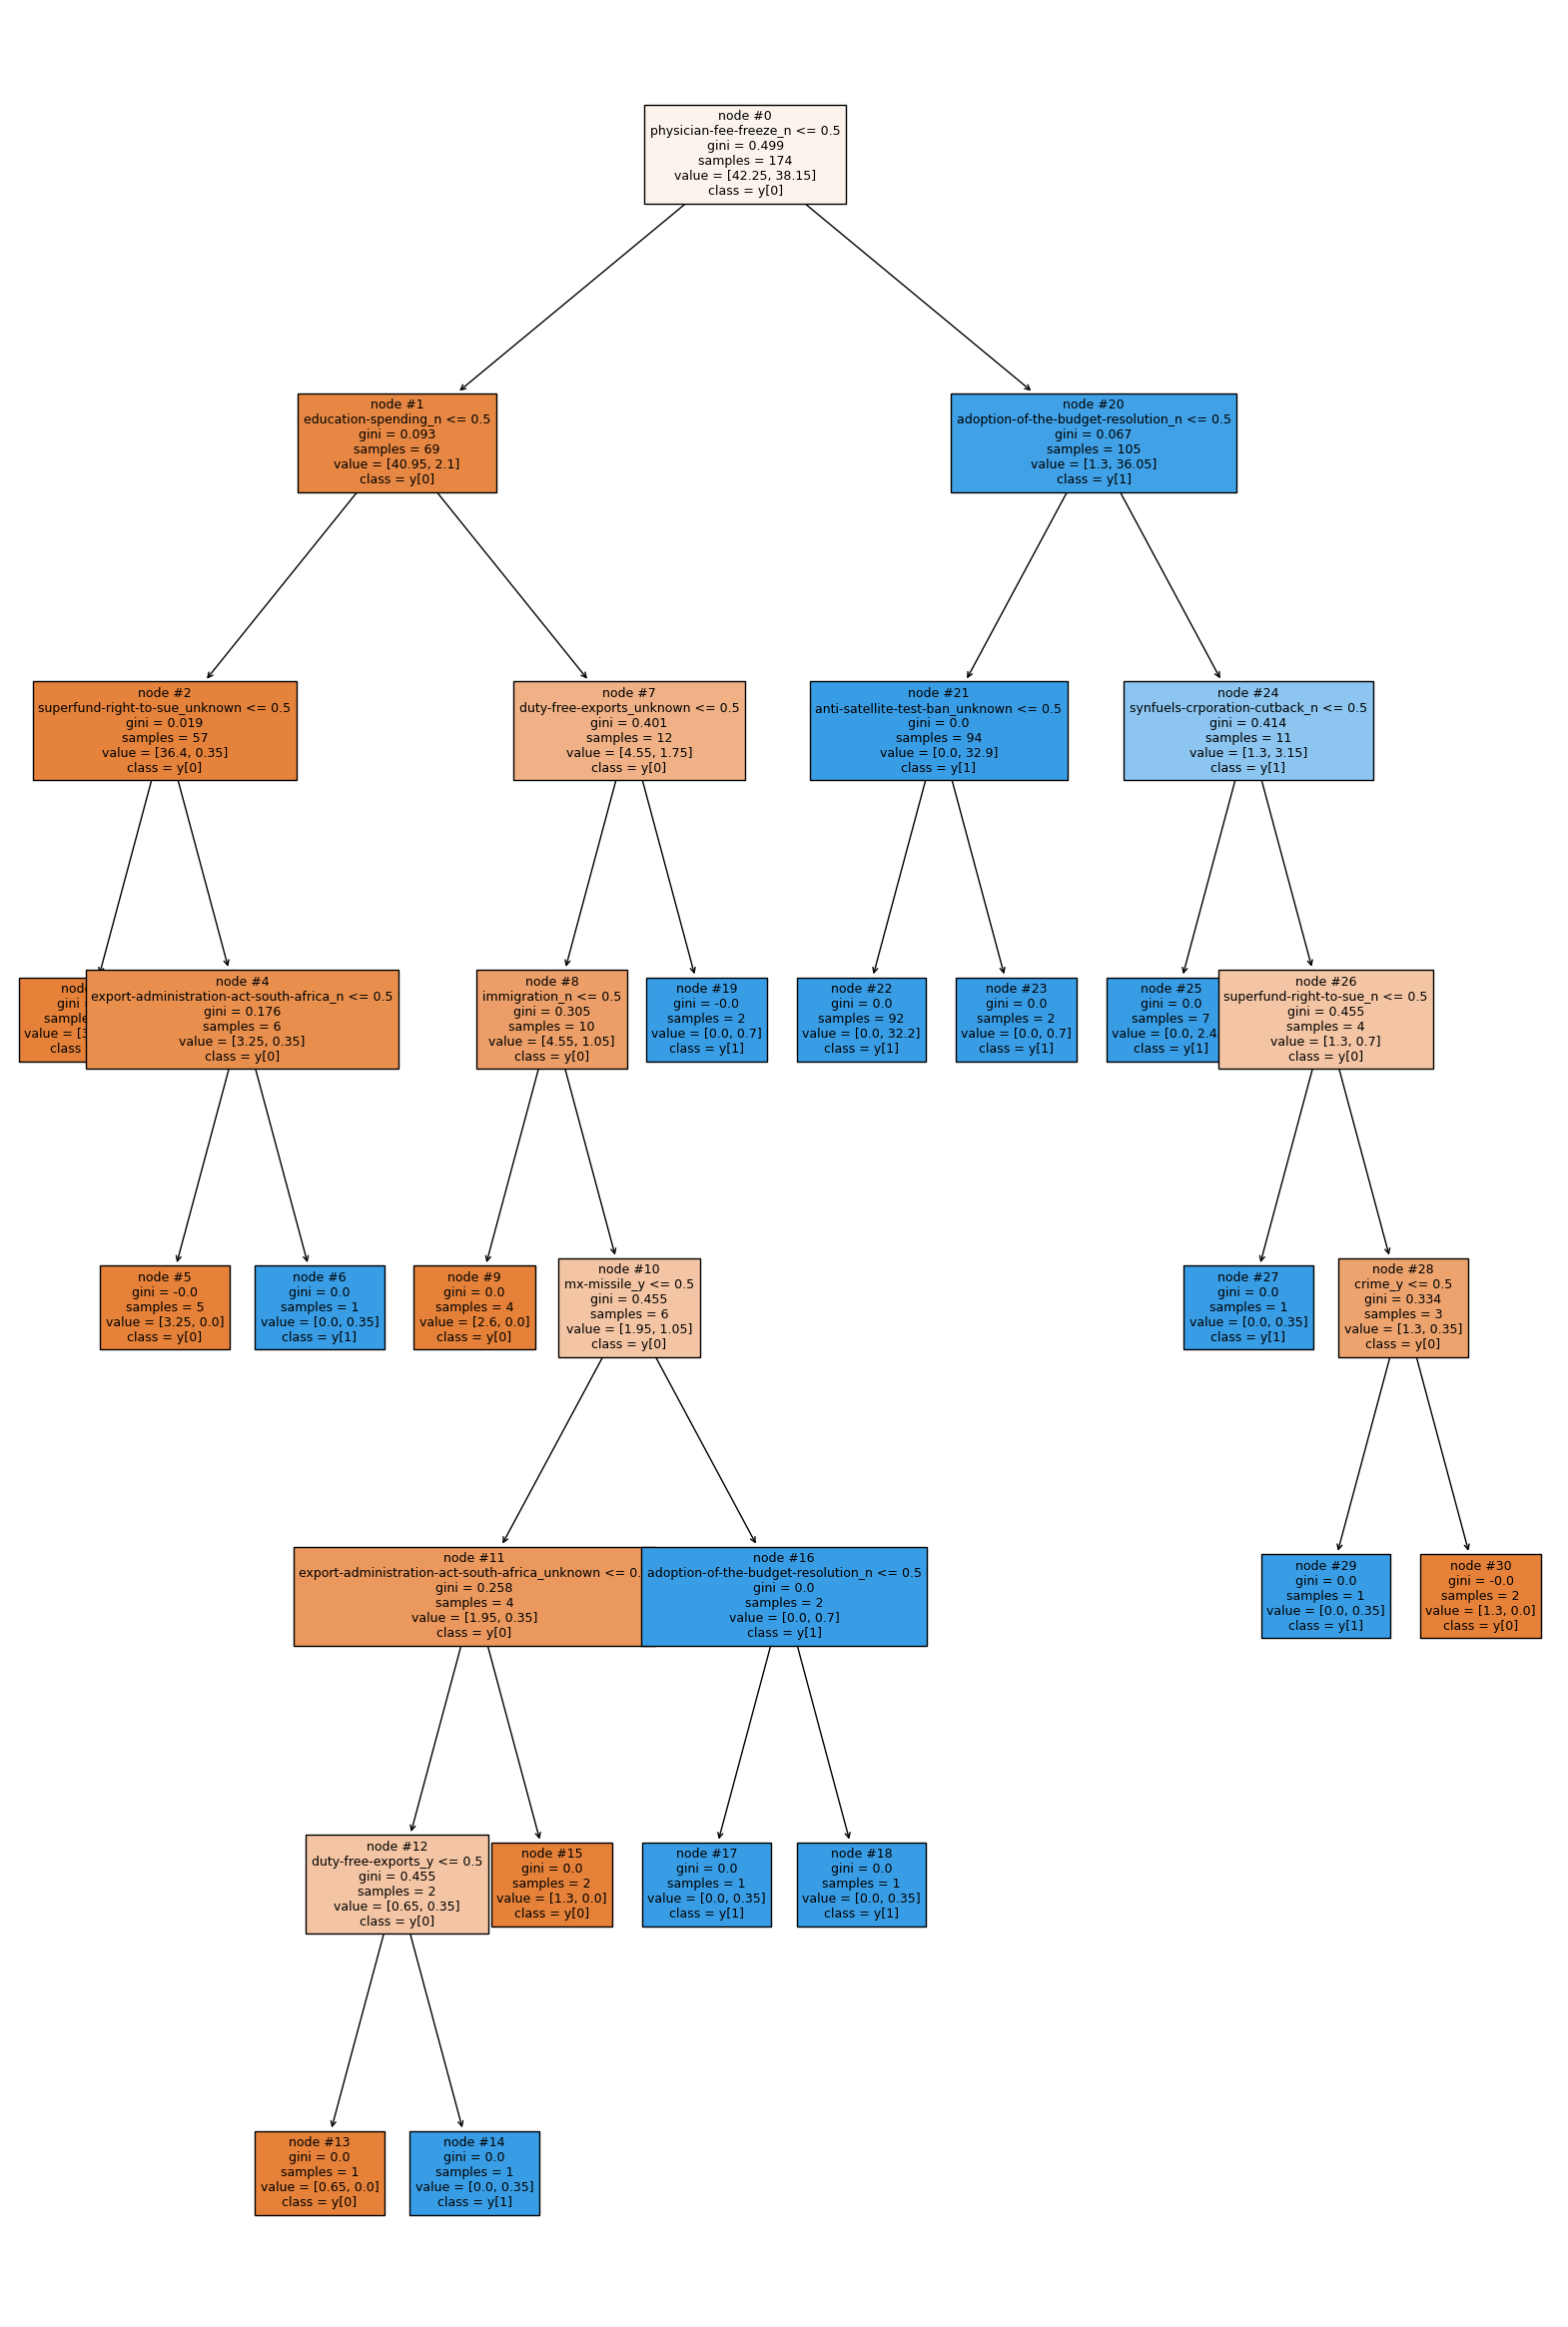

In [111]:
plottree(tree_model_random)

In [97]:
# function for plotting the features
def plot_features(model):
    feat_dict= {}
    for col, val in sorted(zip(features, model.feature_importances_),key=lambda x:x[1],reverse=True):
        feat_dict[col]=val
    feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})
    values = feat_df.Importance    
    idx = feat_df.Feature
    plt.figure(figsize=(10,8))
    clrs = ['navy']
    sns.barplot(y=idx,x=values,palette=clrs).set(title='Important features to predict client subscription')
    plt.show()

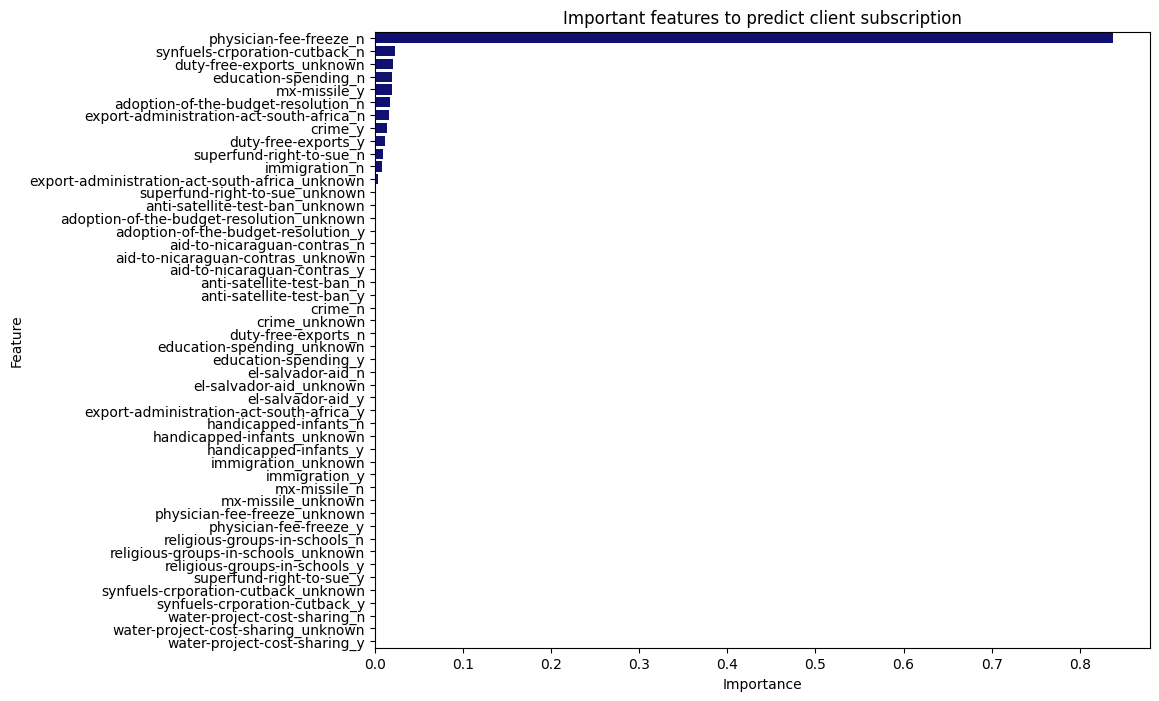

In [112]:
plot_features(tree_model_random)

Observations:
- The most important features include `physician-fee-freeze_n`, `synfuels-crporation-cutback_n`,  `duty-free-exports-unknown`, `education-spending_n`,`mix-missile_y`,`adoption-of-the-budget-resolution_n`, `export-administration-act-south-africa_n`, `crime_y`, `duty-free-exports_y`, `superfund-right-to-sue_n` and `immigration_n`.

##### Fitting another random model

In [123]:
tree_model_random2 = tree.DecisionTreeClassifier(class_weight={1:0.80,0:0.20}, max_depth = 7,random_state=1,criterion = 'log_loss')
tree_model_random2.fit(X_train,y_train)

DecisionTreeClassifier(class_weight={0: 0.2, 1: 0.8}, criterion='log_loss',
                       max_depth=7, random_state=1)

####################
Accuracy on train:  1.0
Accuracy on test:  0.9318181818181818
####################
Confusion Matrix on train:
Confusion Matrix on test:


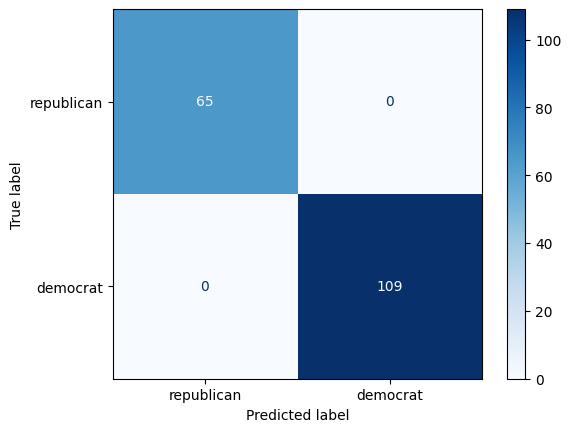

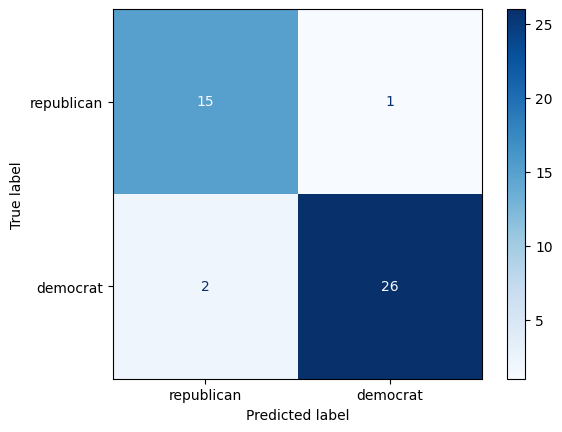

In [124]:
evaluate(tree_model_random2)

Observations:
- The model is still quite overfitted but the accuracy on the test set has increased

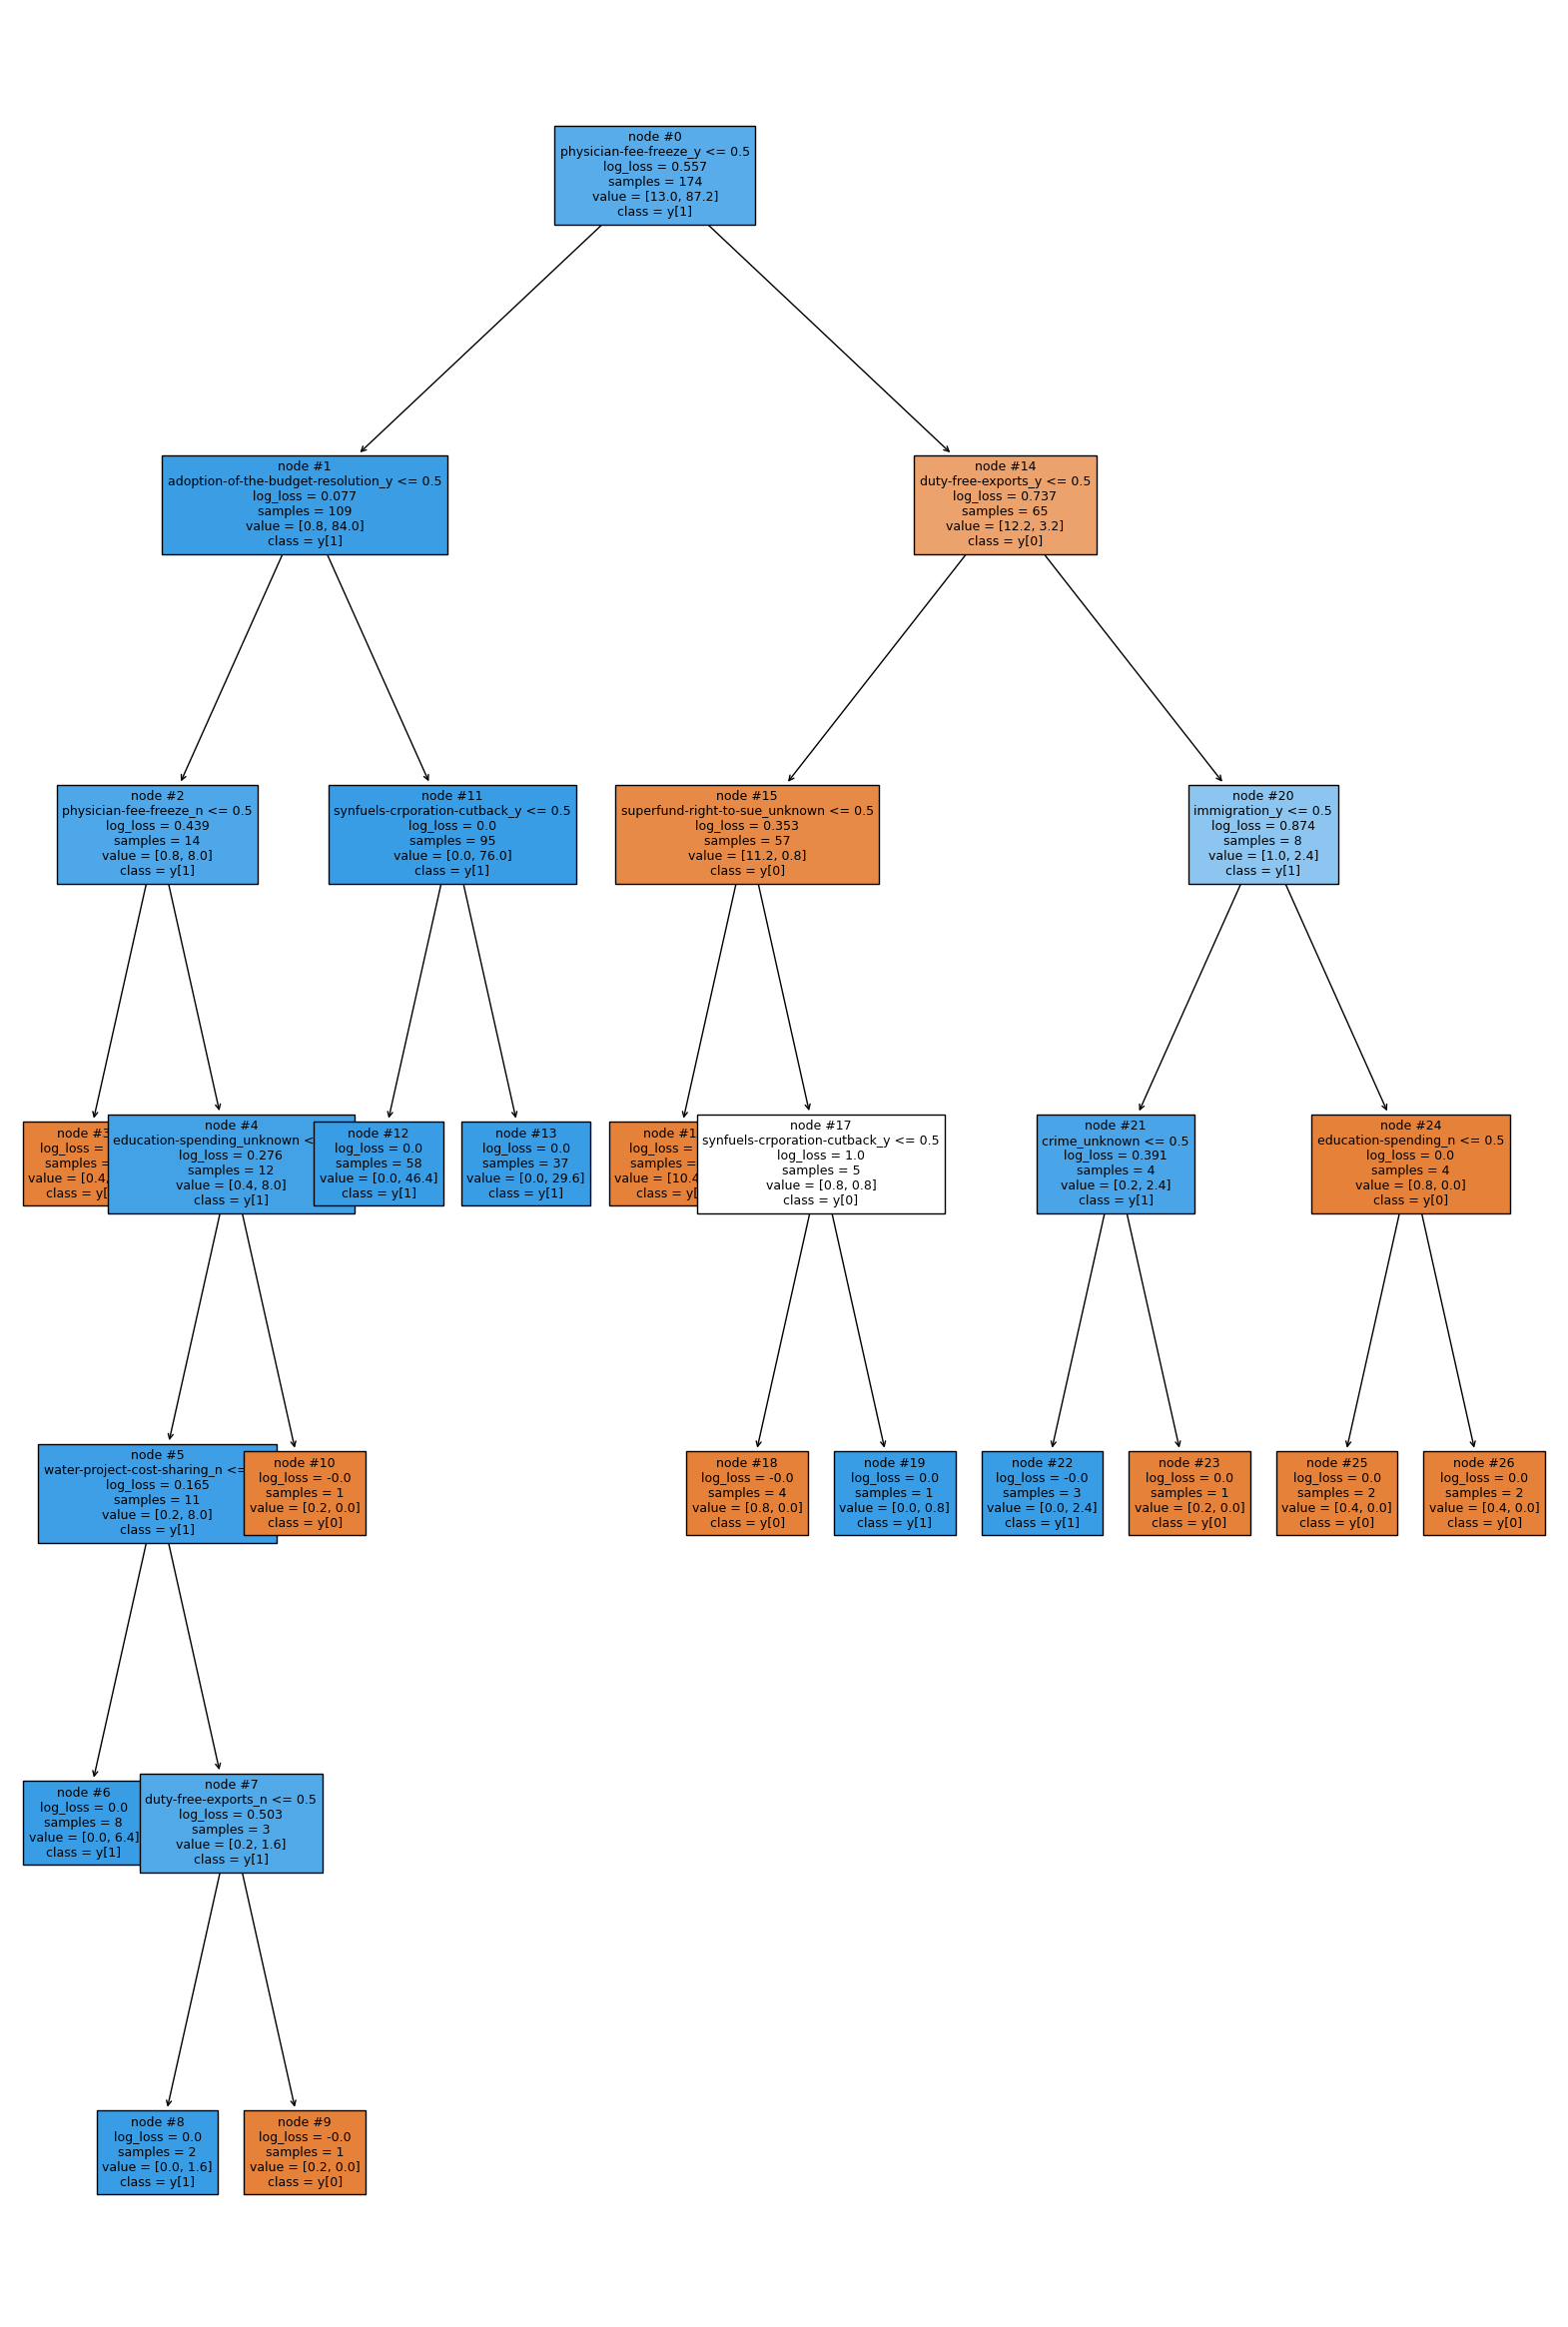

In [125]:
plottree(tree_model_random2)

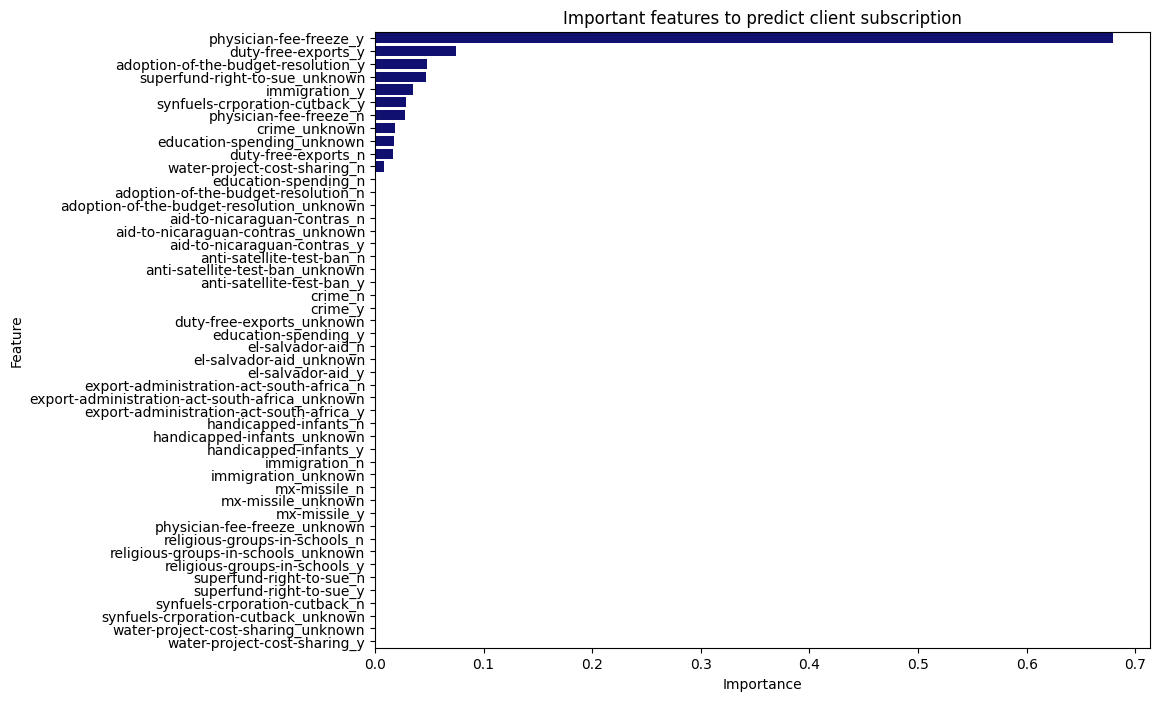

In [126]:
plot_features(tree_model_random2)

##### Grid search for paramter tuning

In [115]:
estimator  = tree.DecisionTreeClassifier(random_state=1)

parameters = {'max_depth': np.arange(1,10), 
              'min_samples_leaf': [1, 2, 5, 7, 10,15,20],
              'max_leaf_nodes' : [5, 10,15,20,25,30],
              'class_weight':[{1:0.25,0:0.75},{1:0.20,0:0.80},{1:0.35,0:0.65}],
              'criterion': ['gini','entropy','log_loss']}
              
scorer = make_scorer(recall_score)

grid = GridSearchCV(estimator = estimator,param_grid = parameters,scoring = scorer, cv = 5)
grid = grid.fit(X_train,y_train)

In [162]:
#best combination
tree_model_best = grid.best_estimator_
tree_model_best

DecisionTreeClassifier(class_weight={0: 0.75, 1: 0.25}, criterion='entropy',
                       max_depth=5, max_leaf_nodes=10, random_state=1)

In [163]:
tree_model_best.fit(X_train,y_train)

DecisionTreeClassifier(class_weight={0: 0.75, 1: 0.25}, criterion='entropy',
                       max_depth=5, max_leaf_nodes=10, random_state=1)

####################
Accuracy on train:  0.9827586206896551
Accuracy on test:  0.9545454545454546
####################
Confusion Matrix on train:
Confusion Matrix on test:


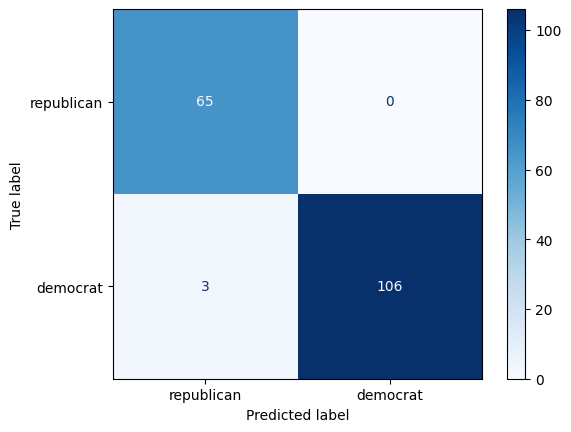

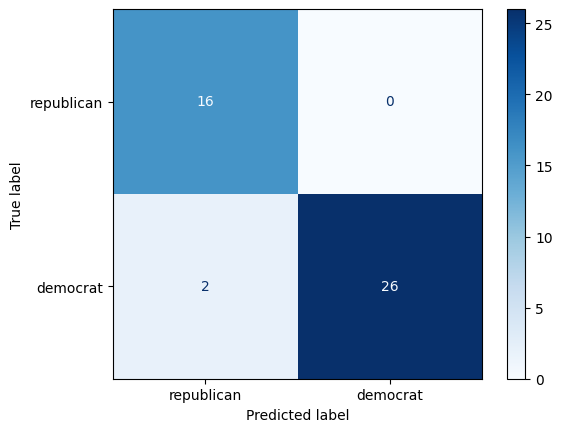

In [164]:
evaluate(tree_model_best)

##### Cost complexity pruning

In [213]:
ccp = tree_model_best.cost_complexity_pruning_path(X_train,y_train)
ccp_alphas, impurities = ccp.ccp_alphas, ccp.impurities

In [214]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(criterion ='entropy',max_depth = 5, max_leaf_nodes=10, class_weight={0: 0.75, 1: 0.25}, random_state=1,ccp_alpha = ccp_alpha)
    clf.fit(X_train,y_train)
    clfs.append(clf)

In [215]:
def plot_ccp(clfs):
    train_acc = []
    test_acc = []

    for c in clfs:
        y_train_predict = c.predict(X_train)
        y_test_predict = c.predict(X_test)
        train_acc.append(accuracy_score(y_train,y_train_predict))
        test_acc.append(accuracy_score(y_test,y_test_predict))

    plt.scatter(ccp_alphas,train_acc)
    plt.scatter(ccp_alphas,test_acc)
    plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle = 'steps-post')
    plt.plot(ccp_alphas,test_acc,label = 'test_accuracy',drawstyle = 'steps-post')
    plt.legend()
    plt.title('Accuracy vs Alpha')
    plt.show()

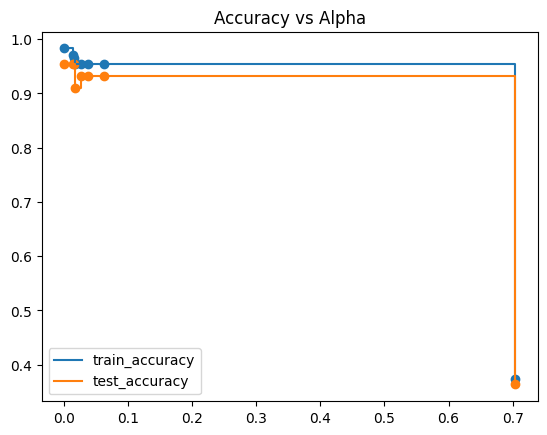

In [216]:
plot_ccp(clfs)

Observations:
- Post pruning would not result in better fit for test...